# Momentum

최저점에 빨리 도달하여 보자.

In [4]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
import time
import numpy as np
from collections import OrderedDict as OD

from dataset.mnist import load_mnist as load
import matplotlib.pyplot as plt
import pickle

In [5]:
class Affine: # 정리된 계층(활성함수 like ReLU에 넣기 전)
    def __init__(self, W, b):
        self.W = W # 행렬값
        self.b = b # 역치
        self.x = None # 입력값
        self.dW = None # W변화량(기울기)
        self.db = None # b변화량(기울기)
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b # 값 계산
        
        return out
    
    def backward(self, dout): # 역전파 첫 입력값
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        return dx

In [6]:
class Softmax:
    def __init__(self):
        self.loss = None
        self.y = None
        self.x = None
        
    def forward(self, x, t): # 입력과 정답에 대해
        self.t = t
        self.y = softmax(x) # softmax는 commom/function에 있음
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t)/batch_size # 어파인 원소 하나당 오차를 전파해야 함
        
        return dx

In [7]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

In [13]:
class Learning:
    def __init__(self, insize, hidsize, outsize, weight = 0.01):
        self.params = {}
        self.params['W1'] = weight * np.random.randn(insize, hidsize) / np.sqrt(2/insize) # He initial W
        self.params['W2'] = weight * np.random.randn(hidsize, outsize) / np.sqrt(2/hidsize)
        self.params['b1'] = weight * np.zeros(hidsize)
        self.params['b2'] = weight * np.zeros(outsize)
        
        self.layers = OD()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = Softmax()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x) # 순전파 계산
            
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return self.lastLayer.forward(y,t) # 교차엔트로피 오차계산
    
    def grad_back(self, x, t):
        self.loss(x,t)
        
        dout = 1 # initialize
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['W2'] = self.layers['Affine2'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

In [14]:
class Momentum:
    def __init__(self, learn = 0.01, momentum = 0.9):
        self.learn = learn
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {} # initialize
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.learn*grads[key]
            params[key] += self.v[key]

In [15]:
(x_tr, t_tr), (x_te, t_te) = load(one_hot_label = True)

In [27]:
iters_num = 60000
train_size = x_tr.shape[0]
batch_size = 500
learning_rate = 0.1

In [28]:
net = Learning(insize = 784, hidsize = 50, outsize = 10)

In [29]:
now = time.time()
train_loss = []
moment = Momentum()
for i in range(iters_num):
    slicing = np.random.choice(train_size, batch_size)
    x_batch = x_tr[slicing]
    t_batch = t_tr[slicing]
    
    gradient = net.grad_back(x_batch, t_batch)
    
    
    moment.update(net.params, gradient)
        
    loss = net.loss(x_batch, t_batch)
    train_loss.append(loss)
    
    elapsed_time = (time.time()-now)
    second = elapsed_time%60
    minute = elapsed_time//60%60
    hour = elapsed_time//3600
    
    print('calc {0:.2f}% done. elapsed : {1:.0f}h {2:.0f}m {3:.0f}s'.format((i+1)*100/iters_num,hour, minute, second), end = '\r')


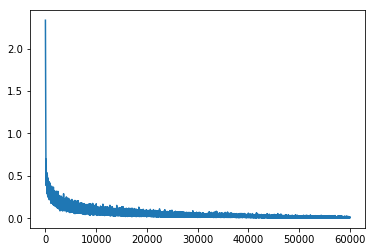

In [30]:
with open('common/params_dict6.pkl', 'wb') as f:
    pickle.dump(net.params, f)
    

plt.plot(range(iters_num), train_loss)
plt.show()

In [31]:
accuracy = 0
for i in range(10000):
    if np.argmax(softmax(net.predict(x_te[i]))) == np.argmax(t_te[i]):
        accuracy += 1
        
print(accuracy/10000)
        

0.9699
